In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

path_to_train_csv = "./IA1_train.csv"
path_to_dev_csv = "./IA1_dev.csv"

originalData = pd.read_csv(path_to_train_csv)
testData = pd.read_csv(path_to_dev_csv)

## Data preprocessing

1. Add dummy feature for constant
2. Compute age_since_renovated
3. Normalize data

In [157]:
dateformat = originalData["date"].str.split("/", expand = True)
originalData['year'] = dateformat[2].astype(int)
originalData['month'] = dateformat[1].astype(int)
originalData['day'] = dateformat[0].astype(int)
originalData['W0'] = 1
originalData['age_since_renovated'] = np.where(originalData['yr_renovated'] == 0, originalData['year'] - originalData['yr_built'], originalData['year'] - originalData['yr_renovated'])

normalizeData = (originalData - originalData.mean()) / originalData.std()
normalizeData['W0'] = originalData['W0']
normalizeData['waterfront'] = originalData['waterfront']
normalizeData['price'] = originalData['price']

trainingData = normalizeData.drop(['date', 'id', 'yr_renovated'], axis = 1)
trainingData.head()

,W0,age_since_renovated,bathrooms,bedrooms,condition,day,floors,grade,lat,long,...,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,year,yr_built,zipcode
0,1,0.587803,-1.465613,-0.388520,-0.634184,-0.513736,-0.922332,-0.563015,-0.308988,-0.932779,...,-0.662576,-1.159110,-1.018504,-0.171139,-0.185644,-0.304487,0,-0.682211,-0.509385,0.512279
1,1,0.137857,0.169158,-0.388520,0.888924,-0.193377,0.917732,0.290361,-1.816632,-1.179633,...,-0.662576,0.145003,0.004058,-0.168133,-0.162508,-0.304487,0,-0.682211,-0.068396,-1.040633
2,1,-1.004315,0.496112,0.649956,-0.634184,-1.474814,0.917732,0.290361,-1.521596,0.428443,...,-0.662576,0.298428,1.494077,-0.219787,-0.238313,-0.304487,0,1.465639,1.084961,-0.685148
3,1,2.283754,-0.811705,-0.388520,-0.634184,-0.513736,0.917732,0.290361,0.540053,-1.017415,...,-0.662576,-0.457738,-0.434182,-0.244481,-0.298603,-0.304487,0,-0.682211,-2.171576,0.755506
4,1,-0.554368,0.496112,-0.388520,0.888924,0.767701,0.917732,1.997115,0.943294,0.781091,...,-0.662576,0.364182,0.471515,-0.122419,-0.155295,-0.304487,0,-0.682211,0.610049,-0.498050


## Part 1

In [158]:
initial_guess = np.repeat([0.5],22)
featureData = trainingData.drop(['price'], axis = 1)
def BatchGradientDescentRecurse(featureDataframe, actualValue, initialGuess, maxSteps, iteration, minErr, learningRate, returnDict):
    dfSize = len(featureDataframe)
    gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(initialGuess).sum(axis=1) - actualValue), axis = 0).sum().values
    normGradient = np.linalg.norm(gradientLw)
    nextW = initialGuess - learningRate*gradientLw
    updateReturn = {'w': initialGuess, 'gradientLw': normGradient, 'n': iteration}
    if (normGradient > minErr and not np.isinf(normGradient) and maxSteps >= 0):
        return BatchGradientDescent(featureDataframe, actualValue, nextW, maxSteps, iteration+1, minErr, learningRate, updateReturn)
    return returnDict

def BatchGradientDescent(featureDataframe, actualValue, initialGuess, maxSteps, minErr, learningRate):
    iteration = 0
    
    dfSize = len(featureDataframe)
    nextW = initialGuess
    gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(initialGuess).sum(axis=1) - actualValue), axis = 0).sum().values
    normGradient = np.linalg.norm(gradientLw)
    MeanSquareError = (1/dfSize)*((featureDataframe.mul(nextW).sum(axis=1) - actualValue)**2).sum()
    MSEs = [MeanSquareError]
    while (normGradient > minErr and not np.isinf(normGradient) and iteration < maxSteps):
        nextW = nextW - learningRate*gradientLw
        gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(nextW).sum(axis=1) - actualValue), axis = 0).sum().values
        normGradient = np.linalg.norm(gradientLw)
        MeanSquareError = (1/dfSize)*((featureDataframe.mul(nextW).sum(axis=1) - actualValue)**2).sum()
        MSEs.append(MeanSquareError)
        iteration += 1
    
    return {'w': dict(zip(featureDataframe.columns.values, nextW)), 'gradientLw': normGradient, 'n': iteration, 'MSE': MSEs}


In [159]:
Rate0 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 10)

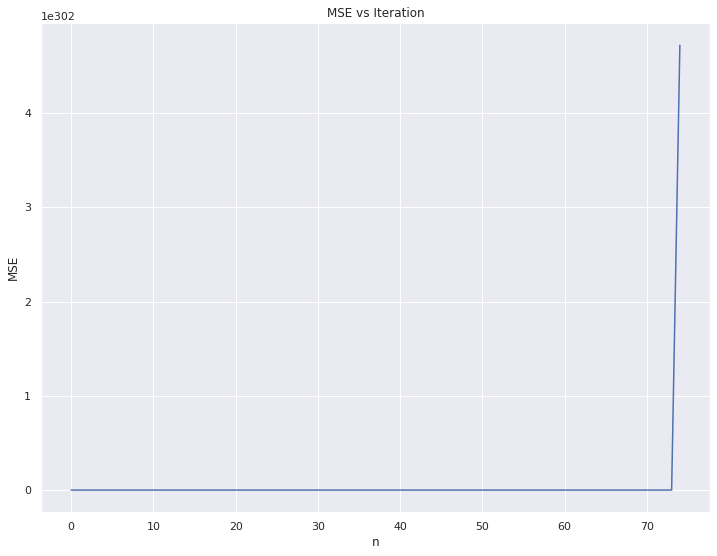

In [160]:
plt.subplots(figsize=(12, 9))
plt.title("MSE vs Iteration")
ax = sns.lineplot(x = list(range(0,Rate0['n']+1)), y = Rate0['MSE'])
ax.set(xlabel='n', ylabel='MSE')
plt.show()

In [161]:
Rate1 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.1)

In [162]:
Rate2 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.01)

In [163]:
Rate3 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.001)

In [164]:
Rate4 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.0001)

In [165]:
Rate5 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.00001)

In [166]:
Rate6 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.05, 0.000001)

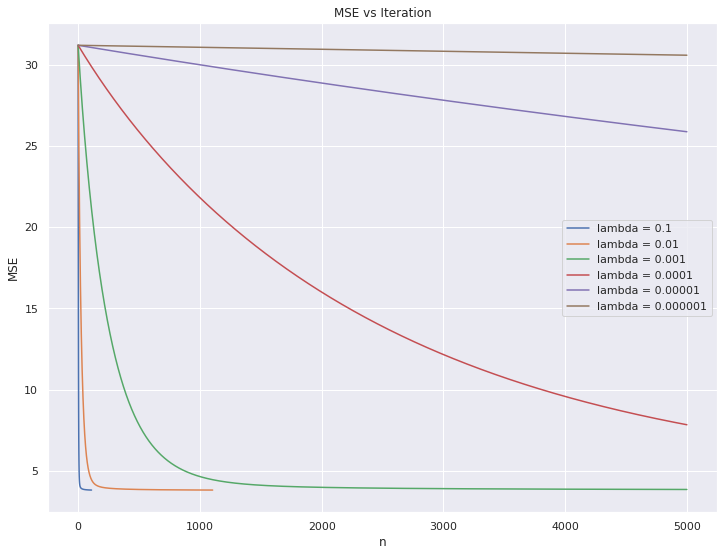

In [167]:
plt.subplots(figsize=(12, 9))
plt.title("MSE vs Iteration")
ax1 = sns.lineplot(x = list(range(0,Rate1['n']+1)), y = Rate1['MSE'], label='lambda = 0.1')
ax2 = sns.lineplot(x = list(range(0,Rate2['n']+1)), y = Rate2['MSE'], label='lambda = 0.01')
ax3 = sns.lineplot(x = list(range(0,Rate3['n']+1)), y = Rate3['MSE'], label='lambda = 0.001')
ax4 = sns.lineplot(x = list(range(0,Rate4['n']+1)), y = Rate4['MSE'], label='lambda = 0.0001')
ax5 = sns.lineplot(x = list(range(0,Rate5['n']+1)), y = Rate5['MSE'], label='lambda = 0.00001')
ax6 = sns.lineplot(x = list(range(0,Rate6['n']+1)), y = Rate6['MSE'], label='lambda = 0.000001')
ax6.set(xlabel='n', ylabel='MSE')
ax6.legend()
plt.show()

In [168]:
testdateformat = testData["date"].str.split("/", expand = True)
testData['year'] = testdateformat[2].astype(int)
testData['month'] = testdateformat[1].astype(int)
testData['day'] = testdateformat[0].astype(int)
testData['W0'] = 1
testData['age_since_renovated'] = np.where(testData['yr_renovated'] == 0, testData['year'] - testData['yr_built'], testData['year'] - testData['yr_renovated'])

normalizetestData = (testData - originalData.mean()) / originalData.std()
normalizetestData['W0'] = testData['W0']
normalizetestData['waterfront'] = testData['waterfront']
normalizetestData['price'] = testData['price']

validatingData = normalizetestData.drop(['date', 'id', 'yr_renovated'], axis = 1)
validatingFeatureData = validatingData.drop(['price'], axis = 1)

validatingData.head()


,W0,age_since_renovated,bathrooms,bedrooms,condition,day,floors,grade,lat,long,...,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,year,yr_built,zipcode
0,1,0.068634,-1.465613,0.649956,0.888924,0.447342,-0.002300,-0.563015,1.226067,-0.156953,...,-0.662576,-0.611163,-0.653303,-0.125186,-0.172715,-0.304487,0,-0.682211,-0.000551,-0.834826
1,1,-0.415923,0.169158,-0.388520,-0.634184,-1.154455,-0.922332,0.290361,-1.291481,1.204269,...,0.390996,-0.304313,0.018666,0.020425,0.083587,-0.304487,0,1.465639,0.508283,-0.759987
2,1,0.518580,-0.811705,-0.388520,0.888924,1.728779,-0.922332,-0.563015,-0.314038,-0.298012,...,1.055205,-0.326231,-0.302710,-0.239710,-0.179520,5.014070,0,-0.682211,-0.441541,0.736796
3,1,1.210806,-1.465613,-1.426996,0.888924,-0.193377,-0.922332,-0.563015,-0.079596,-1.151421,...,-0.250308,-0.918013,-1.091544,-0.206307,-0.216946,1.025152,0,-0.682211,-1.119986,0.886474
4,1,-0.485146,0.169158,-0.388520,-0.634184,1.088060,-0.922332,-0.563015,-2.142687,-0.213377,...,1.169724,0.123085,-0.726343,-0.148234,-0.136445,-0.304487,0,-0.682211,0.542205,-1.452249


In [169]:
Rate1MSE = (1/len(validatingData))*((validatingFeatureData.mul(list(Rate1['w'].values())).sum(axis=1) - validatingData['price'])**2).sum()
print(f'MSE for learning rate = 0.1: {Rate1MSE}')

MSE for learning rate = 0.1: 4.702285056495035


In [170]:
Rate2MSE = (1/len(validatingData))*((validatingFeatureData.mul(list(Rate2['w'].values())).sum(axis=1) - validatingData['price'])**2).sum()
print(f'MSE for learning rate = 0.01: {Rate2MSE}')

MSE for learning rate = 0.01: 4.702179285832164


In [171]:
print(f'Learning rate = 0.1 final W: \n{Rate1["w"]}')

Learning rate = 0.1 final W: 
{'W0': 5.355385392865069, 'age_since_renovated': 0.04325974025936799, 'bathrooms': 0.3428541144875039, 'bedrooms': -0.2891845255143054, 'condition': 0.1944276026908868, 'day': 0.062456346315222885, 'floors': 0.020533211323749353, 'grade': 1.0941988201977544, 'lat': 0.8348482263796266, 'long': -0.3114215886949374, 'month': -0.04801993311171038, 'sqft_above': 0.8594014369829838, 'sqft_basement': 0.1878541873110137, 'sqft_living': 0.6781106664603087, 'sqft_living15': 0.13221296139622113, 'sqft_lot': 0.06122307924642335, 'sqft_lot15': -0.10109650611571022, 'view': 0.5520747442992242, 'waterfront': 0.9489619288565505, 'year': 0.17357631626400044, 'yr_built': -0.7440664574780976, 'zipcode': -0.26342731813903847}


## Part 2

In [172]:
anomalousTrainingData = originalData.drop(['date', 'id', 'yr_renovated'], axis = 1)
anomalousFeatureData = anomalousTrainingData.drop(['price'], axis = 1)

In [173]:
anomalousRate0 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 10)
anomalousRate1 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.1)
anomalousRate2 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.01)
anomalousRate3 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.001)
anomalousRate4 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.0001)
anomalousRate5 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.00001)
anomalousRate6 = BatchGradientDescent(anomalousFeatureData, anomalousTrainingData['price'], initial_guess, 5000, 0.05, 0.000001)

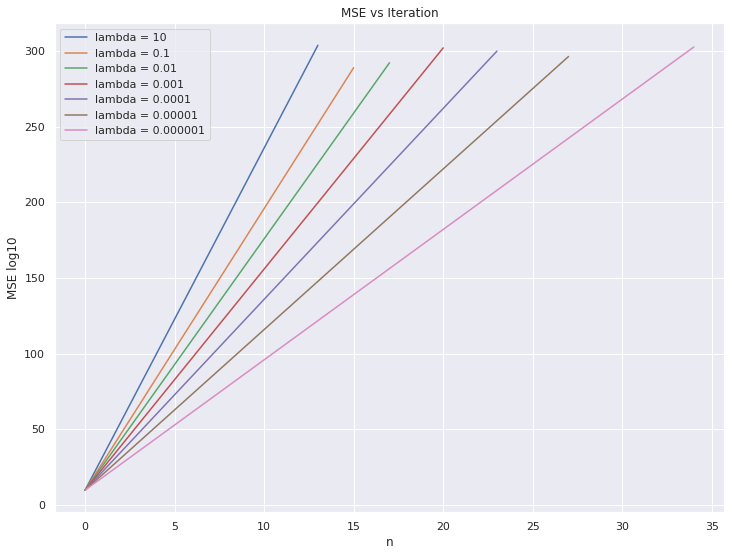

In [174]:
plt.subplots(figsize=(12, 9))
plt.title("MSE vs Iteration")
ax1 = sns.lineplot(x = list(range(0,anomalousRate0['n']+1)), y = np.log10(anomalousRate0['MSE']), label='lambda = 10')
ax1 = sns.lineplot(x = list(range(0,anomalousRate1['n']+1)), y = np.log10(anomalousRate1['MSE']), label='lambda = 0.1')
ax2 = sns.lineplot(x = list(range(0,anomalousRate2['n']+1)), y = np.log10(anomalousRate2['MSE']), label='lambda = 0.01')
ax3 = sns.lineplot(x = list(range(0,anomalousRate3['n']+1)), y = np.log10(anomalousRate3['MSE']), label='lambda = 0.001')
ax4 = sns.lineplot(x = list(range(0,anomalousRate4['n']+1)), y = np.log10(anomalousRate4['MSE']), label='lambda = 0.0001')
ax5 = sns.lineplot(x = list(range(0,anomalousRate5['n']+1)), y = np.log10(anomalousRate5['MSE']), label='lambda = 0.00001')
ax6 = sns.lineplot(x = list(range(0,anomalousRate6['n']+1)), y = np.log10(anomalousRate6['MSE']), label='lambda = 0.000001')

ax6.set(xlabel='n', ylabel='MSE log10')
ax6.legend()
plt.show()

In [175]:
np.log10([10,100,1000])

array([1., 2., 3.])

## Part 3

In [176]:
leanTrainingData = normalizetestData.drop(['date', 'id', 'yr_renovated', 'sqft_living15'], axis = 1)
leanFeatureData = leanTrainingData.drop(['price'], axis = 1)
originalGuess = Rate1['w'].copy()
originalGuess.pop('sqft_living15')
originalGuess = list(originalGuess.values())
leanRate1 = BatchGradientDescent(leanFeatureData, leanTrainingData['price'], originalGuess, 5000, 0.05, 0.1)

In [177]:
leanValidatingData = validatingData.drop(['sqft_living15'], axis = 1)
leanValidatingFeatureData = leanValidatingData.drop(['price'], axis = 1)

In [178]:
finalMSE = (1/len(leanValidatingData))*((leanValidatingFeatureData.mul(list(leanRate1['w'].values())).sum(axis=1) - leanValidatingData['price'])**2).sum()
print(f'MSE for learning rate = 0.1: {finalMSE}')

MSE for learning rate = 0.1: 4.4697000431686575


In [179]:
leanRate1['w']

{'W0': 5.395093412571355,
 'age_since_renovated': -0.14818130575892643,
 'bathrooms': 0.4091160792453757,
 'bedrooms': -0.2735031821453542,
 'condition': 0.21941807269457508,
 'day': 0.021417280449153222,
 'floors': 0.033334572459592794,
 'grade': 1.336236130365973,
 'lat': 0.8608620420264024,
 'long': -0.3623135252299304,
 'month': -0.04744529974821569,
 'sqft_above': 0.7266083562654528,
 'sqft_basement': 0.35201054634944284,
 'sqft_living': 0.6356625725160046,
 'sqft_lot': 0.05490634034213192,
 'sqft_lot15': -0.10046895431203487,
 'view': 0.5740021642133395,
 'waterfront': 2.939767398672385,
 'year': 0.17648097474052796,
 'yr_built': -0.800072824538892,
 'zipcode': -0.34593640149717336}